## PQuant MSstats: Proteomics differential expression downstream analysis 

The following Jupyter notebooks allows to perform differential expression data analysis from multiple pipelines developed by the bigbio team. The output of the following pipelines are supported: 

- [proteomicsLFQ](https://github.com/nf-core/proteomicslfq): LFQ pipeline based on OpenMS and nextflow. 

The following Notebook uses [MSstats](https://www.bioconductor.org/packages/release/bioc/html/MSstats.html) to perform the downstream data analysis of the data. Major steps in the data processing are the following: 

- Importing data from the pipeline. The major sources of data are:
  - out.mzTab: The mzTab file format containing the PSMs, Peptides and proteins. 
  - out_msstats.csv: Input of MSstats. 
  - metadata.sdrf.tsv: File with the metadata sample information in [SDRF](https://github.com/bigbio/proteomics-metadata-standard). 
  
## TOC:

* [Load the data into MSstats](#first)
* [QCPlot: MS Runs Log intensity normalization](#second)
  * [Inspect one specific protein across samples and group Comparisons](#protein)
* [Generation of Group comparisons](#volcanos)
* [Conditions Heatmaps](#heatmaps)
  

## Load the data into MSstats  <a class="anchor" id="first"></a>

The data for the analysis will be storage in the `data folder`. The input for the analysis `out_msstats.csv` is stored in that folder. In the following step, **CONTAMINAT** proteins are removed from the the input before the downsdtream analysis. 

The peptide expression table is load processed using the MSstats fiunction [MSstats::dataProcess](https://rdrr.io/bioc/MSstats/man/dataProcess.html). The following paraemters are used: 

- summaryMethod = `TMT` : 'TMP' means Tukey's median polish, which is robust estimation method.
- normalization = `equalizeMedians` : 'equalizeMedians' represents constant normalization (equalizing the medians) based on reference signals is performed.
- censoredInt = `NA` : Missing values are censored or at random. 'NA' assumes that all 'NA's in 'Intensity' column are censored. 
- MBimpute = `TRUE`: Imputes 'NA' or '0' (depending on censoredInt option) by Accelated failure model.


In [37]:
import warnings
warnings.filterwarnings('ignore')
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [38]:
%%R
data_folder = '../data/'
msstats_output = '../data/MSstats_output.csv'
msstats_input  = '../data/out_msstats.csv'
protein_expression = '../data/protein_expression.csv'

fileData <- read.csv(msstats_input)

## Remove CONTAMINAT proteins 
fileData <- fileData[!grepl("CONTAMINANT", fileData$ProteinName),]
print(paste('Number of Unique Peptides:',length(unique(fileData[["PeptideSequence"]]))))
print(paste('Number of Unique Protein Groups:',length(unique(fileData[["ProteinName"]]))))

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)
#library(reticulate)


# If run dataProcess() occuring an error message, please change "summaryMethod = 'TMP'" to "summaryMethod = 'linear'"
DDA2009.proposed <- MSstats::dataProcess(raw = fileData,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(DDA2009.proposed$ProteinLevelData)
Protein.Expression <- DDA2009.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)


[1] "Number of Unique Peptides: 32830"
[1] "Number of Unique Protein Groups: 4215"
INFO  [2021-07-26 08:25:24] ** Features with one or two measurements across runs are removed.
INFO  [2021-07-26 08:25:24] ** Fractionation handled.
INFO  [2021-07-26 08:25:28] ** Updated quantification data to make balanced design. Missing values are marked by NA
INFO  [2021-07-26 08:25:41] ** Log2 intensities under cutoff = 14.987  were considered as censored missing values.
INFO  [2021-07-26 08:25:41] ** Log2 intensities = NA were considered as censored missing values.
INFO  [2021-07-26 08:25:41] ** Use all features that the dataset originally has.
INFO  [2021-07-26 08:25:44] 
 # proteins: 3941
 # peptides per protein: 1-234
 # features per peptide: 1-1
INFO  [2021-07-26 08:25:44] Some proteins have only one feature: 
 sp|A0A075B6H7|KV37_HUMAN,
 sp|A0A075B6R9|KVD24_HUMAN;sp|A0A0C4DH68|KV224_HUMAN,
 sp|A0A075B6S5|KV127_HUMAN;sp|A0A0C4DH67|KV108_HUMAN;sp|A0A0C4DH69|KV109_HUMAN,
 sp|A0A087WSX0|LV545_HUMAN

## QCPlot: MS Runs Log intensity normalization <a class="anchor" id="second"></a>

To identify potential sources of variation for each protein; (2) quality control plot (specify "QCPlot") is used to evaluate the systematic bias between MS runs across conditions, the plot helps to illustrate mean and variability of MSruns across conditions. The plot illustrate the systematic bias between MS runs. After normalization, the reference signals for all proteins should be stable across MS runs. 


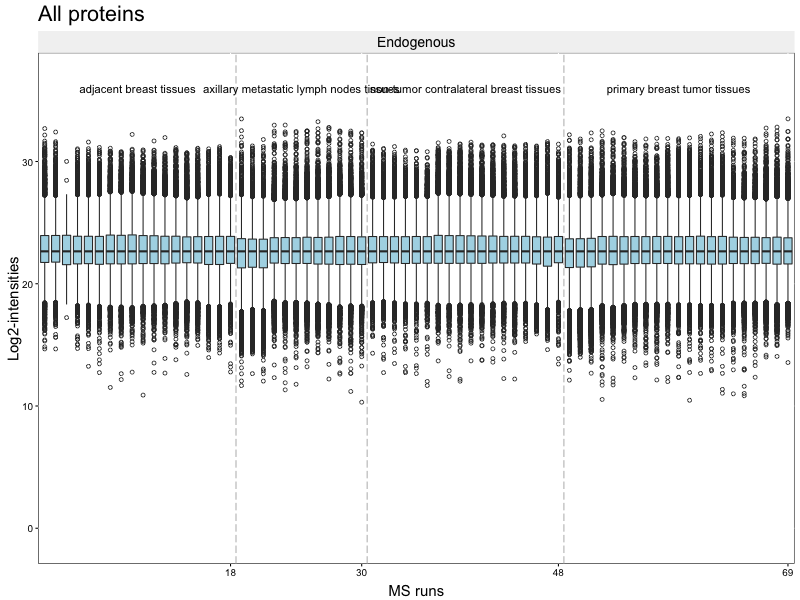

In [39]:
%%R -w 800 -h 600
tmp <- levels(DDA2009.proposed$ProcessedData$PROTEIN)
selector <- append('allonly', tmp, 1)
dataProcessPlots(data = DDA2009.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

## Inspect one specific protein across samples and group Comparisons <a class="anchor" id="protein"></a>

In this section, users can select an specific protein and generate a set of QC plots and expression plots to inspect the Protein expression across the entire experiment. The following plots are generated: 

- The `Log2-Intensities` distribution of the protein across all MS runs and conditions. 
- The `Log2-Intensities` distribution of each independent detencted peptide for the given protein.

[1] "sp|O75558|STX11_HUMAN"
  |======                                                                |   9%


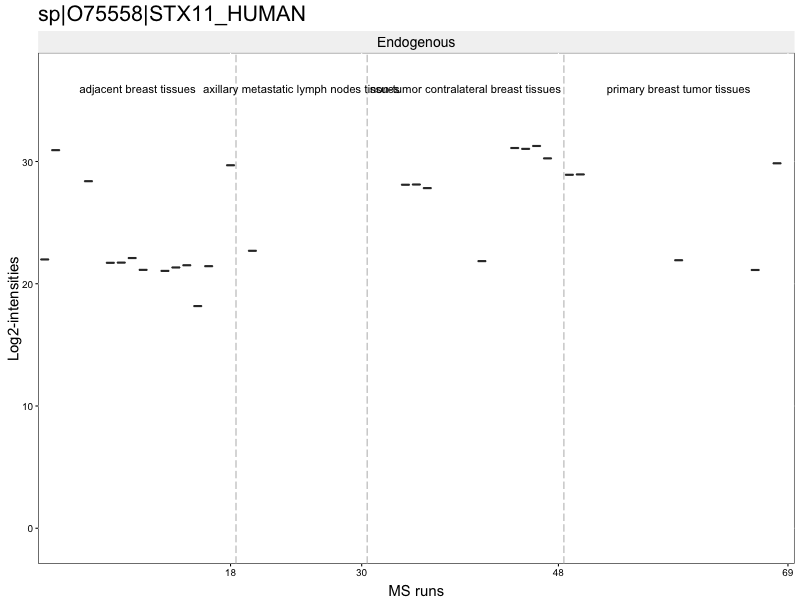

In [40]:
%%R -w 800 -h 600
Protein.Expression2 <- Protein.Expression[order(Protein.Expression$LogIntensities,decreasing = TRUE),]
protein_accession <- as.character(Protein.Expression2$Protein[1])
print(protein_accession)
tmp <- levels(DDA2009.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = DDA2009.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

  |======================================================================| 100%
  |======================================================================| 100%


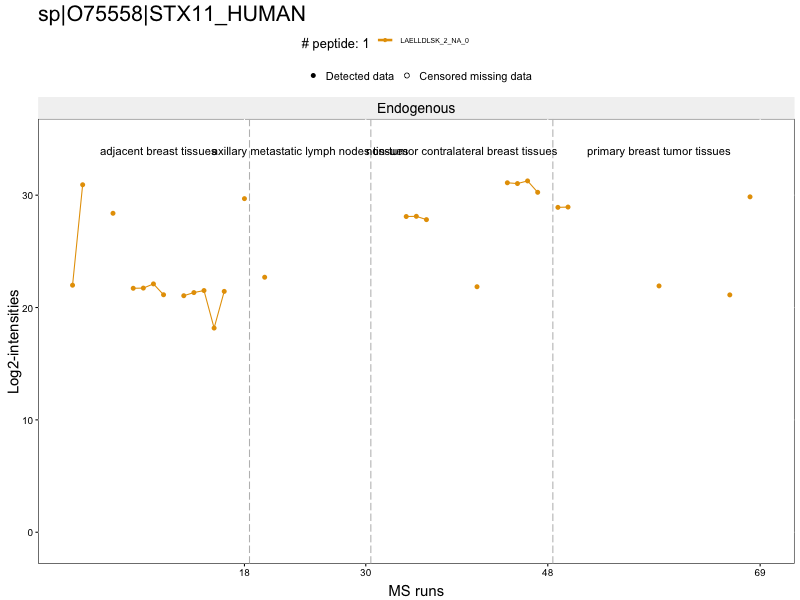

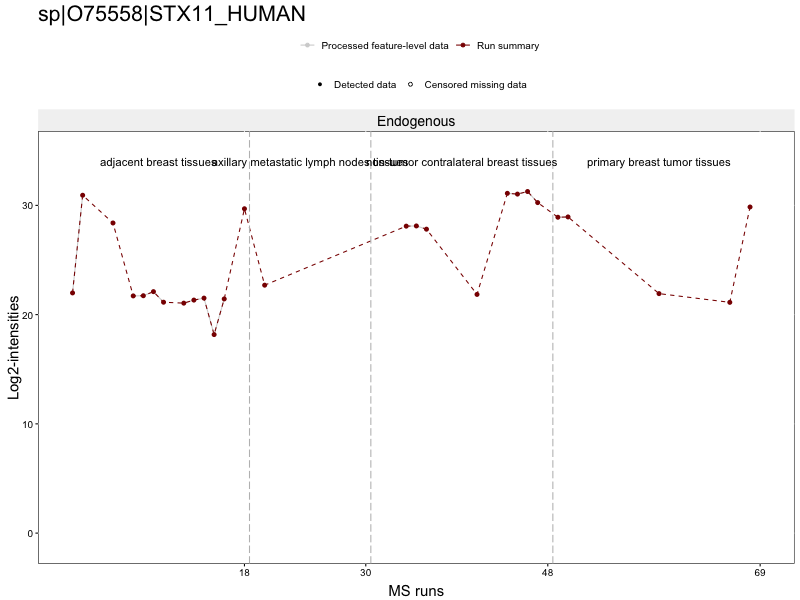

In [41]:
%%R -w 800 -h 600

tmp <- levels(DDA2009.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = DDA2009.proposed, type="ProfilePlot",which.Protein=selector,width=10, height=5, address=FALSE)

  |======                                                                |   9%


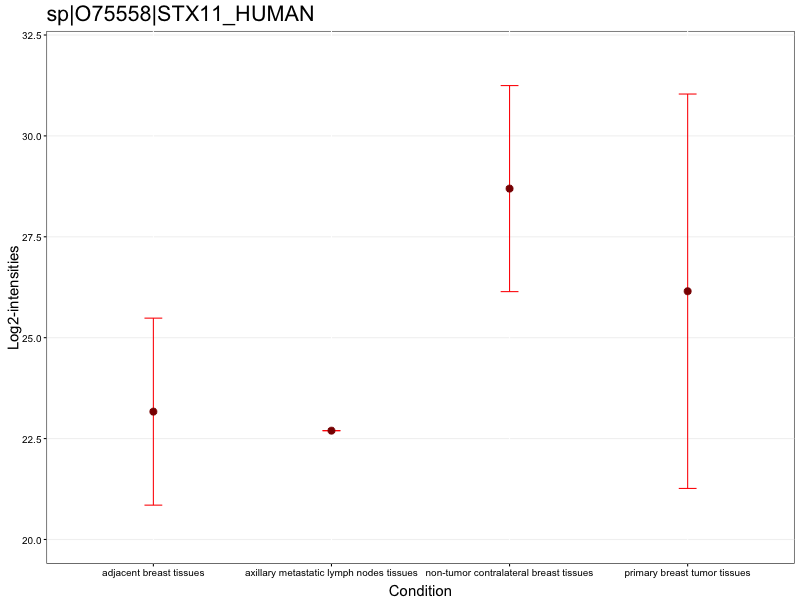

In [42]:
%%R -w 800 -h 600

tmp <- levels(DDA2009.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = DDA2009.proposed, type="ConditionPlot",which.Protein=selector,width=10, height=5, address=FALSE)

## Generation of Group comparisons <a class="anchor" id="volcanos"></a>

In this step all group comparisons between conditions in the experiment are generate. The `comparsion matrix` is generated using the MSstats function `MSstats::groupComparison`. 

Heapmaps for each indenpendent comparison is generated using a default Adjusted p-value of 0.05 as a thershold to classified as a significant change `Down-regulated` (blue dots) or `Up-regulated` (red dots).

In [43]:
%%R -w 800 -h 600

len <- length(levels(DDA2009.proposed$FeatureLevelData$GROUP))

ourMatrix <- matrix(c(0:0),nrow=len,ncol=len)
diag(ourMatrix) = -1
for(i in 1:len-1){
  ourMatrix[i,i+1] = 1
}
ourMatrix[len,1] = 1

ourCondition <- levels(DDA2009.proposed$ProteinLevelData$GROUP)
len2 <- length(ourCondition)
tmp <- matrix(ourCondition, nr=len2, nc=1)
name <- matrix(nr=len2, nc=1)
for(i in 1:len2-1){
  name[i,1] <- sprintf('%s-%s', tmp[i+1,1], tmp[i,1])
}
name[len2,1] <- sprintf('%s-%s', tmp[1,1], tmp[len2,1])

row.names(ourMatrix) <- name
#----------End of creation-----------
colnames(ourMatrix) <- ourCondition

DDA2009.comparisons <- MSstats::groupComparison(contrast.matrix = ourMatrix,
                                       data = DDA2009.proposed)

write.csv(DDA2009.comparisons$ComparisonResult, file=msstats_output)

INFO  [2021-07-26 08:35:37]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2021-07-26 08:37:02]  == Comparisons for all proteins are done.


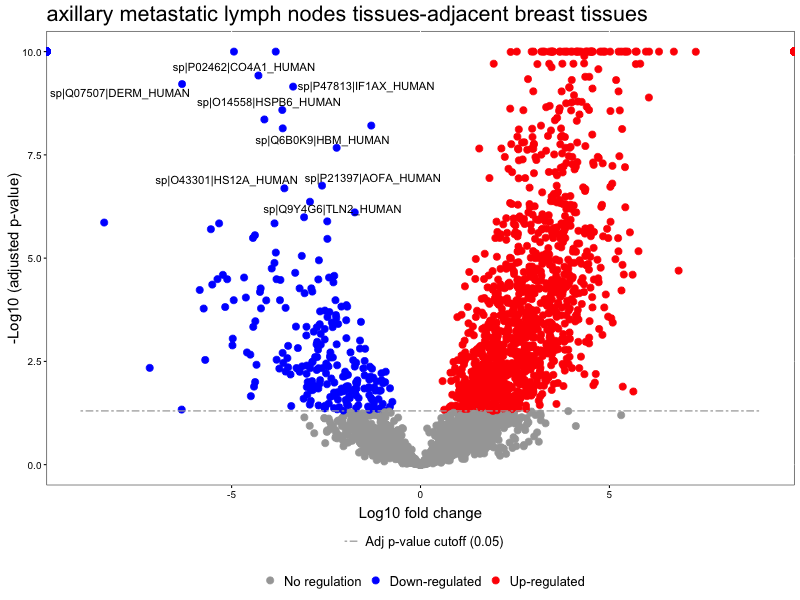

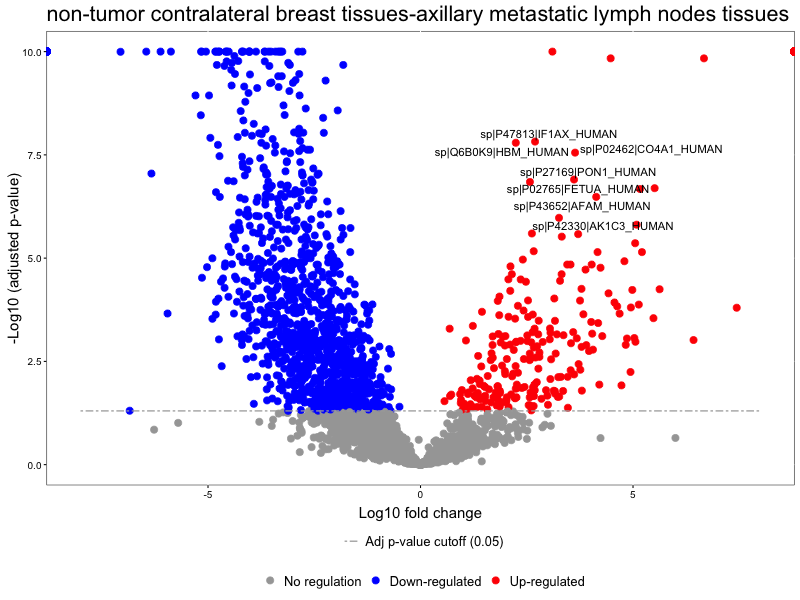

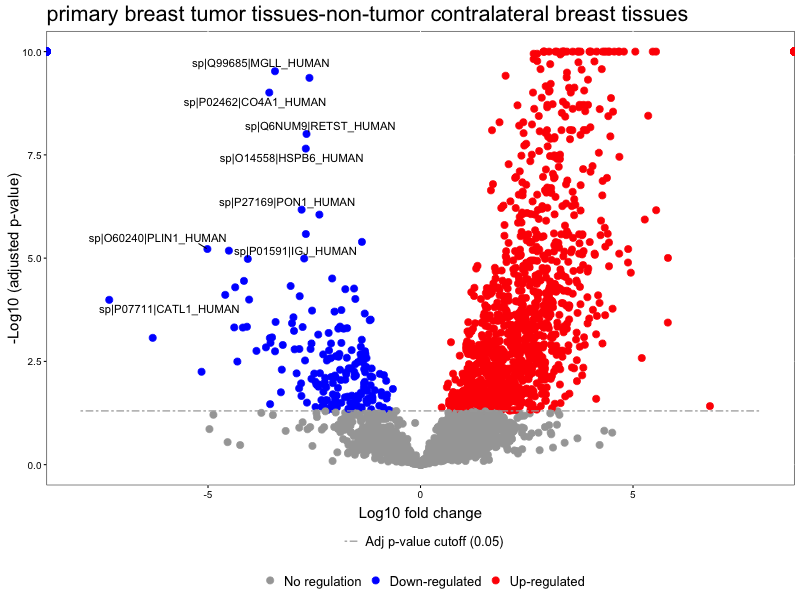

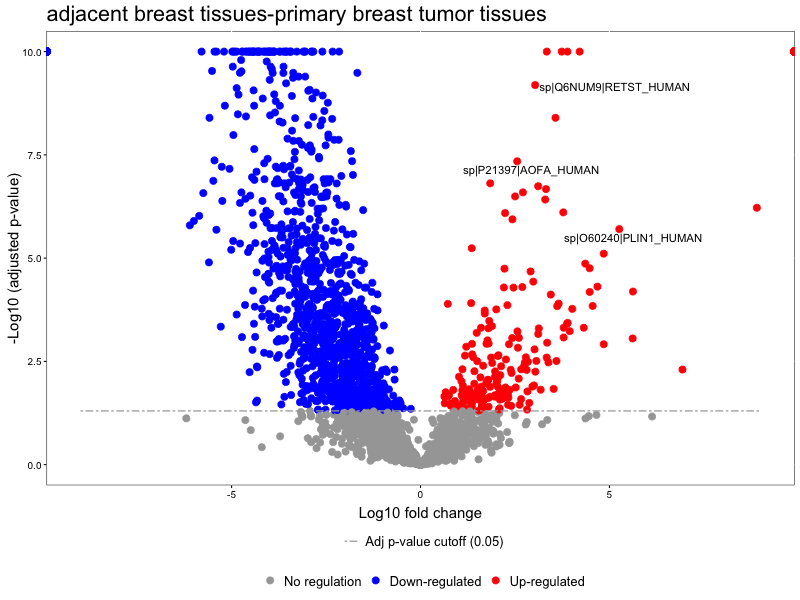

In [44]:
%%R -w 800 -h 600
 
# Automatically create the manually created matrix in MSstats, user manual p23
len <- length(levels(DDA2009.proposed$FeatureLevelData$GROUP))
      
ourMatrix <- matrix(c(0:0),nrow=len,ncol=len)
diag(ourMatrix) = -1
for(i in 1:len-1){
    ourMatrix[i,i+1] = 1
}
ourMatrix[len,1] = 1
      
ourCondition <- levels(DDA2009.proposed$ProteinLevelData$GROUP)
len2 <- length(ourCondition)
tmp <- matrix(ourCondition, nr=len2, nc=1)
name <- matrix(nr=len2, nc=1)

for(i in 1:len2-1){
    name[i,1] <- sprintf('%s-%s', tmp[i+1,1], tmp[i,1])
}
name[len2,1] <- sprintf('%s-%s', tmp[1,1], tmp[len2,1])
for(i in 1: length(name)){
    groupComparisonPlots(data = DDA2009.comparisons$ComparisonResult, type = 'VolcanoPlot',
                       width=5, height=5, address=FALSE, which.Comparison=name[i,1]) 
}


In [45]:
%%R 

# result.sample<-designSampleSize(data=DDA2009.comparisons$FittedModel, numSample=TRUE,
# desiredFC=c(1.25,1.75), FDR=0.05, power=0.8)
# designSampleSizePlots(data=result.sample)

# result.power<-designSampleSize(data=DDA2009.comparisons$FittedModel, numSample=2,
# desiredFC=c(1.25,1.75), FDR=0.05, power=TRUE)
# designSampleSizePlots(data=result.power)


NULL


## Protein expression Heatmaps <a class="anchor" id="heatmaps"></a>

Two Heatmaps are generated: 

 - Condition Heatmap: The condition heatmap clusters the expressed proteins for each condition of the the experiment. 
 
 - Group comparison headmap: The group comparison heatmap allows to create clusters of proteins that change the expression where 2 different conditions are compared. 

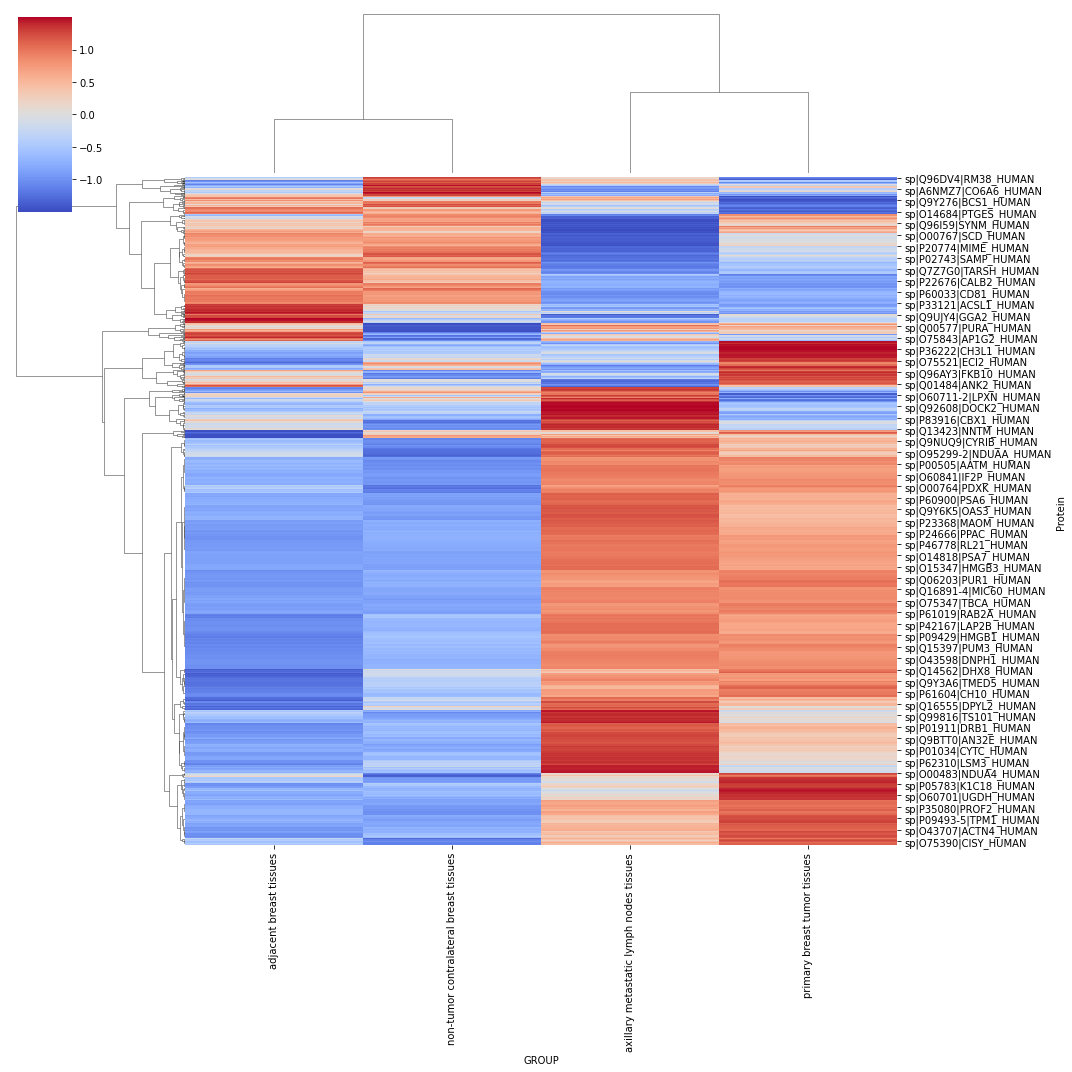

In [46]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
 
# Data set
url = '../data/protein_expression.csv'
df = pd.read_csv(url)
# Remove the Contaminants 
df = df[~df.Protein.str.contains("CONTAMINANT")]
# Remove protein Groups 
df = df[~df.Protein.str.contains(";")]
#print(df) 

df2 = df.pivot_table(index='Protein', columns='GROUP', values='LogIntensities',aggfunc=np.mean)
df2 = df2.dropna()

# plot
g = sns.clustermap(df2, method='average', metric='correlation', z_score=0, figsize=(15,15), xticklabels=True, cmap="coolwarm")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels())#, fontsize = 5)

# tmp = g.ax_heatmap.get_xaxis()

threshold = 0.1
x_labels_ticks = g.ax_heatmap.get_xticklabels()

total_genes_above_threshold = 0
for i, xtickdata in enumerate(x_labels_ticks):
    protein = xtickdata._text
    if df2[protein].max() >= threshold:
        # print(df2[protein])
        # print("#########")
        total_genes_above_threshold = total_genes_above_threshold + 1
        # print(df2[protein].max())
    else:
        xtickdata._text = ''

#print("total_genes_above_threshold {}".format(total_genes_above_threshold))

# re set the tick labels with the modified list
g.ax_heatmap.set_xticklabels(x_labels_ticks)
plt.show()

In [47]:
import numpy as np
import pandas as pd
import os

data_folder = '../data/'
msstats_output = data_folder + 'MSstats_output.csv'
heatmap_output = data_folder + 'pheatmap_input.csv'

MS = pd.read_csv(msstats_output)

MS = MS[~MS['log2FC'].isin([np.inf])]  # By ~ inverse;Without the outermost log2FC[], the output would be True/False
MS = MS[~MS['log2FC'].isin([-np.inf])]

Protein = MS['Protein'].drop_duplicates().tolist()
Label = [str(i) for i in MS['Label'].drop_duplicates().tolist()]
#Label = Label[~pd.isnull(Label)].tolist()
Label = [x for x in Label if x != 'nan']

pHT_Protein = []
pHT_log2FC = []

for i in range(len(Protein)):
    tmp = MS[MS['Protein'].isin([Protein[i]])]
    len_tmp = len(tmp['log2FC'])
    if len_tmp == len(Label):
        pHT_Protein.append(Protein[i])
        pHT_log2FC.append(tmp['log2FC'].tolist())

pHT = pd.DataFrame(pHT_Protein, columns=['Protein'])
for i in range(len(Label)):
    pHT[Label[i]] = [j[i] for j in pHT_log2FC]    # Get every i-th element in a two-dimensional list


#shape[0] 行， shape[1] 列
rows = pHT.shape[0]
cols = pHT.shape[1]

abnormal = []
for i in range(rows):
    if (pHT.iloc[i, 1:cols].min() < -4) or (pHT.iloc[i, 1:cols].max() > 4):
        abnormal.append(i)

for i in range(len(abnormal)):
        pHT.drop(abnormal[i], inplace=True)

pHT.to_csv(heatmap_output, index=False)
    

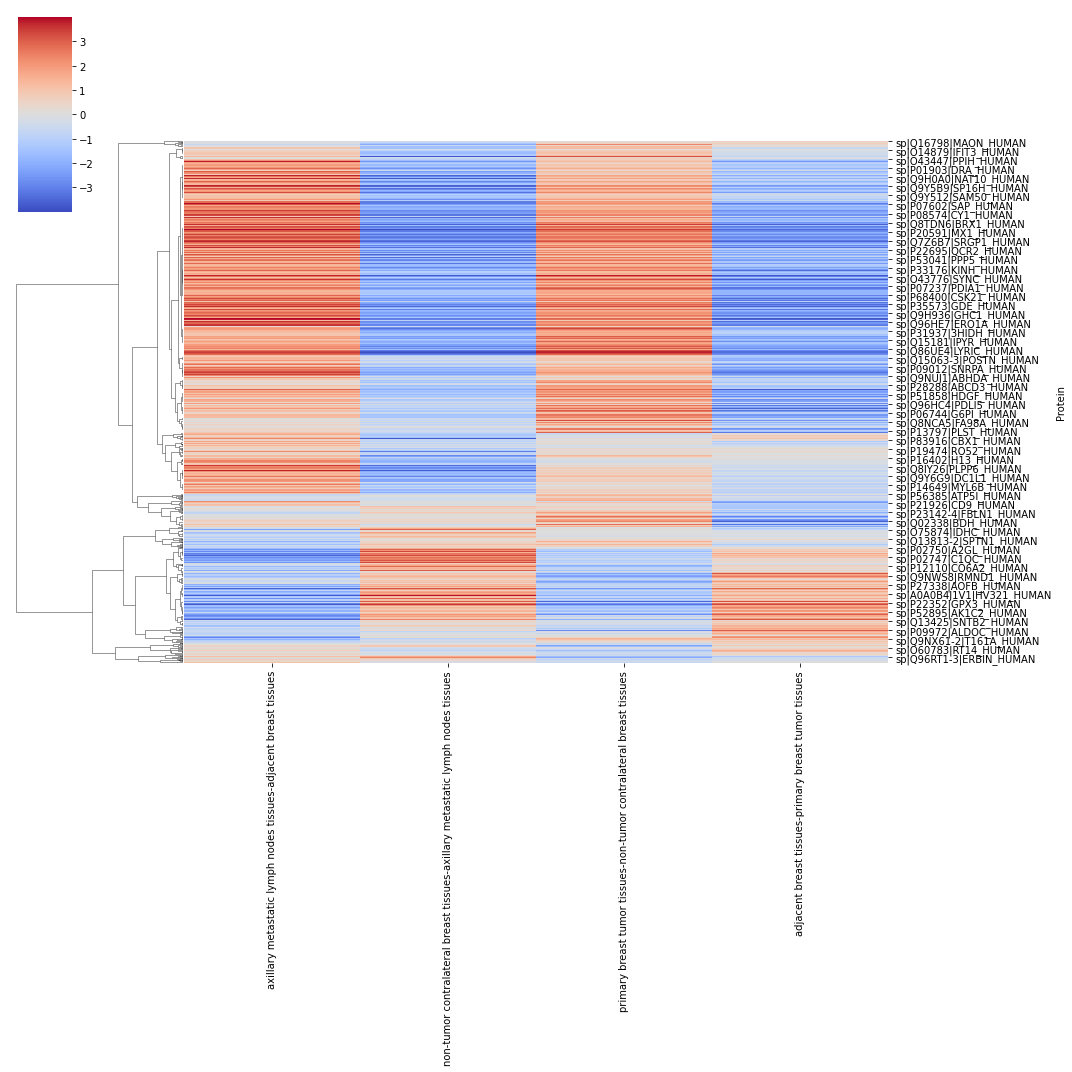

In [48]:
# Data set
url = '../data/pheatmap_input.csv'
df = pd.read_csv(url)
# Remove the Contaminants 
df = df[~df.Protein.str.contains("CONTAMINANT")]
# Remove protein Groups 
df = df[~df.Protein.str.contains(";")]
#print(df) 
df = df.set_index(['Protein'])

# plot
sns.clustermap(df, metric='correlation', figsize=(15,15), xticklabels=True, col_cluster=False, cmap="coolwarm")
plt.show()

### Generation of output file format for Expression Atlas. 

In [49]:
import os, sys
import pandas as pd
import xml.dom.minidom


def get_data1(disease, information, data_dir):

    len_d = len(disease)
    len_i = len(information)

    assay_label = []
    assay_id = []
    assay = []

    contrast_name = []
    contrast_id = []

    g = 1
    g_name = []
    g_id = []
    if len_d >= len_i:
        
        for i in range(len_i):
            for j in range(len_d):

                atmp = df_csv.loc[(df_csv.iloc[:,-1] == information[j]) &
                            (df_csv['characteristics[disease]'] == disease[i])]
                if atmp.empty:
                    continue

                label = information[i] + '; ' + disease[j]
                assay_label.append(label)
                
                aid = 'g' + str(g)
                assay_id.append(aid)
                g += 1

                assay.append(list(atmp['source name']))

                if g % 2 == 0:
                    cid = 'g' + str(g) + '_g' + str(g-1)
                    contrast_id.append(cid)

                    cname = "\'" + disease[j] + "\' vs \'" + disease[j-1] + "\' in \'" + information[i] + "\'"
                    contrast_name.append(cname)

                    gname = disease[j] + '-' + disease[j-1]
                    g_name.append(gname)
                    g_id.append(cid)
                    gname = disease[j-1] + '-' + disease[j]
                    g_name.append(gname)
                    g_id.append(cid)

    else:
        for i in range(len_d):
            for j in range(len_i):

                atmp = df_csv.loc[(df_csv.iloc[:,-1] == information[j]) &
                            (df_csv['characteristics[disease]'] == disease[i])]
                if atmp.empty:
                    continue

                label = disease[i] + '; ' + information[j]
                assay_label.append(label)
                
                aid = 'g' + str(g)
                assay_id.append(aid)
                g += 1
                
                assay.append(list(atmp['source name']))

                if g % 2 == 0:
                    cid = 'g' + str(g) + '_g' + str(g-1)
                    contrast_id.append(cid)

                    cname = "\'" + information[j] + "\' vs \'" + information[j-1] + "\' in \'" + disease[i] + "\'"
                    contrast_name.append(cname)

                    gname = information[j] + '-' + information[j-1]
                    g_name.append(gname)
                    g_id.append(cid)
                    gname = information[j-1] + '-' + information[j]
                    g_name.append(gname)
                    g_id.append(cid)

    gg = g_name + g_id
    gg = ','.join(gg)
    print(gg)

    f = open(data_dir + '/g_g_name.txt', 'w')
    f.write(gg)
    f.close()

    return assay_label, assay_id, assay, contrast_name, contrast_id



def get_data2(disease, information, data_dir, tmp_info0, tmp_info1, judge_information):

    len_d = len(disease)
    len_i = len(information)
    len_i0 = len(tmp_info0)
    len_i1 = len(tmp_info1)

    assay_label = []
    assay_id = []
    assay = []

    contrast_name = []
    contrast_id = []

    g = 1
    g_name = []
    g_id = []
    if len_d >= len_i:
        for i in range(len_i0):
            for x in range(len_i1):
                for j in range(len_d):

                    atmp = df_csv.loc[(df_csv[judge_information[0]] == tmp_info0[i]) &
                                (df_csv[judge_information[1]] == tmp_info1[x]) &
                                (df_csv['characteristics[disease]'] == disease[j])]
                    if atmp.empty:
                        continue

                    label = disease[j] + '; ' + tmp_info0[i] + '|' + tmp_info1[x]
                    assay_label.append(label)
                    
                    aid = 'g' + str(g)
                    assay_id.append(aid)
                    g += 1
                    
                    assay.append(list(atmp['source name']))

                    if g % 2 == 0:
                        cid = 'g' + str(g) + '_g' + str(g-1)
                        contrast_id.append(cid)

                        tmp_info_g = tmp_info0[i] + '|' + tmp_info1[x]
                        tmp_info_g_1 = tmp_info0[i] + '|' + tmp_info1[x-1]

                        cname = "\'" + tmp_info_g + "\' vs \'" + tmp_info_g_1 + "\' in \'" + disease[i] + "\'"
                        contrast_name.append(cname)

                        gname = tmp_info_g + '-' + tmp_info_g_1
                        g_name.append(gname)
                        g_id.append(cid)
                        gname = tmp_info_g_1 + '-' + tmp_info_g
                        g_name.append(gname)
                        g_id.append(cid)

                        g += 2

                        cid = 'g' + str(g) + '_g' + str(g-1)
                        contrast_id.append(cid)

                        tmp_info_g = tmp_info0[j] + '|' + tmp_info1[x]
                        tmp_info_g_1 = tmp_info0[j-1] + '|' + tmp_info1[x-1]

                        cname = "\'" + tmp_info_g + "\' vs \'" + tmp_info_g_1 + "\' in \'" + disease[i] + "\'"
                        contrast_name.append(cname)

                        gname = tmp_info_g + '-' + tmp_info_g_1
                        g_name.append(gname)
                        g_id.append(cid)
                        gname = tmp_info_g_1 + '-' + tmp_info_g
                        g_name.append(gname)
                        g_id.append(cid)


    else:
        for i in range(len_d):
            for j in range(len_i0):
                for x in range(len_i1):

                    atmp = df_csv.loc[(df_csv[judge_information[0]] == tmp_info0[j]) &
                                (df_csv[judge_information[1]] == tmp_info1[x]) &
                                (df_csv['characteristics[disease]'] == disease[i])]
                    if atmp.empty:
                        continue


                    label = disease[i] + '; ' + tmp_info0[j] + '|' + tmp_info1[x]
                    assay_label.append(label)
                    
                    aid = 'g' + str(g)
                    assay_id.append(aid)
                    g += 1
                    
                    assay.append(list(atmp['source name']))

                    if g % 2 == 0:
                        cid = 'g' + str(g) + '_g' + str(g-1)
                        contrast_id.append(cid)

                        tmp_info_g = tmp_info0[j] + '|' + tmp_info1[x]
                        tmp_info_g_1 = tmp_info0[j] + '|' + tmp_info1[x-1]

                        cname = "\'" + tmp_info_g + "\' vs \'" + tmp_info_g_1 + "\' in \'" + disease[i] + "\'"
                        contrast_name.append(cname)

                        gname = tmp_info_g + '-' + tmp_info_g_1
                        g_name.append(gname)
                        g_id.append(cid)
                        gname = tmp_info_g_1 + '-' + tmp_info_g
                        g_name.append(gname)
                        g_id.append(cid)

                        g += 2

                        cid = 'g' + str(g) + '_g' + str(g-1)
                        contrast_id.append(cid)

                        tmp_info_g = tmp_info0[j] + '|' + tmp_info1[x]
                        tmp_info_g_1 = tmp_info0[j-1] + '|' + tmp_info1[x-1]

                        cname = "\'" + tmp_info_g + "\' vs \'" + tmp_info_g_1 + "\' in \'" + disease[i] + "\'"
                        contrast_name.append(cname)

                        gname = tmp_info_g + '-' + tmp_info_g_1
                        g_name.append(gname)
                        g_id.append(cid)
                        gname = tmp_info_g_1 + '-' + tmp_info_g
                        g_name.append(gname)
                        g_id.append(cid)

    gg = g_name + g_id
    gg = ','.join(gg)

    f = open(data_dir + '/g_g_name.txt', 'w')
    f.write(gg)
    f.close()

    return assay_label, assay_id, assay, contrast_name, contrast_id





def get_xml(assay_label, assay_id, assay, contrast_name, contrast_id, data_dir):
    doc = xml.dom.minidom.Document()

    root = doc.createElement('Configuration')
    root.setAttribute('experimentType', 'rnaseq_mrna_differential')
    root.setAttribute('r_data', '0')
    doc.appendChild(root)

    node_analytics = doc.createElement('analytics')
    root.appendChild(node_analytics)

    node_assayGs = doc.createElement('assay_groups')
    node_analytics.appendChild(node_assayGs)

    node_contrasts = doc.createElement('contrasts')
    node_analytics.appendChild(node_contrasts)

    for i in range(len(assay_id)):
        node_assayG = doc.createElement('assay_group')
        node_assayG.setAttribute('id', assay_id[i])
        node_assayG.setAttribute('label', assay_label[i])
        node_assayGs.appendChild(node_assayG)
        
        for j in range(len(assay[i])):
            node_assay = doc.createElement('assay')
            node_assay.appendChild(doc.createTextNode(assay[i][j]))
            node_assayG.appendChild(node_assay)
        


    for i in range(len(contrast_id)):
        node_contrast = doc.createElement('contrast')
        node_contrast.setAttribute('id', contrast_id[i])
        node_contrast.setAttribute('cttv_primary', '1')
        node_contrasts.appendChild(node_contrast)

        node_c_name = doc.createElement('name')
        node_c_name.appendChild(doc.createTextNode(contrast_name[i]))

        node_c_ref = doc.createElement('reference_assay_group')
        node_c_ref.appendChild(doc.createTextNode(contrast_id[i][:2]))

        node_c_test = doc.createElement('test_assay_group')
        node_c_test.appendChild(doc.createTextNode(contrast_id[i][-2:]))

        node_contrast.appendChild(node_c_name)
        node_contrast.appendChild(node_c_ref)
        node_contrast.appendChild(node_c_test)


    fp = open(data_dir + '/NAME_configuration.xml', 'w')
    doc.writexml(fp, indent='\t', addindent='\t', newl='\n', encoding="utf-8")
    fp.close()

def get_convert_exp_values(data_dir): 
    name_data = pd.read_csv(data_dir + 'g_g_name.txt', sep = ',')


    for(i in 1:(length(name_data)/2)){
        data = read.csv("./MSstats_output.csv")
  
  temp.name = name_data[,i]
  data <- data[which(data$Label %in% temp.name), ]
  
  if (any(is.na(data))) {
      matrix_final = data.frame((Protein = data$Protein))
      colnames(matrix_final)[1] <- 'Protein'
      break
  }
}



for(i in 1:(length(name_data)/2)){
  data <- read.csv("./MSstats_output.csv")
  
  temp.name = name_data[,i]
  data <- data[which(data$Label %in% temp.name), ]
  
  if (any(is.na(data))) {
      num = 1
      
      name_p = paste(name_data[,i+length(name_data)/2], '.p-value', sep = '')
      name_log2fc = paste(name_data[,i+length(name_data)/2], '.log2foldchange', sep = '')
      
      matrix_tmp = data.frame(pp = data$pvalue, llog2 = data$log2FC)
      colnames(matrix_tmp)[1] <- name_p
      colnames(matrix_tmp)[2] <- name_log2fc
      
      matrix_final = cbind(matrix_final, matrix_tmp)
  }
  else{
      next
  }
}


### Delete lines containing 'NA'
matrix_final = na.omit(matrix_final)

write.csv(matrix_final, file = './NAME_analytics.csv', quote = F, row.names = F)

}

data_dir = '../data/'

sdrfName = 'PXD015270-cell-lines.sdrf.tsv'
csv = data_dir  + "/" + sdrfName
df_csv = pd.read_csv(csv, sep='\t')


rownames = list(df_csv.columns)
low_rownames = [i.lower() for i in rownames]
df_csv.columns = low_rownames

disease = df_csv['characteristics[disease]']
disease = sorted(disease.unique())

all_information = list(df_csv)
judge_information = list(filter(lambda x: len(x) != len(x.replace('factor','')),all_information))

if len(judge_information) == 1:
    information = sorted(df_csv[judge_information[0]].unique())

    assay_label, assay_id, assay, contrast_name, contrast_id = get_data1(disease, information, data_dir)

elif len(judge_information) == 2:
    for i in range(2):
        exec("tmp_info%s = sorted(df_csv[judge_information[%s]].unique())"%(i,i))
        
    information = []
    for i in range(len(tmp_info0)):
        for j in range(len(tmp_info1)):
            information.append(tmp_info0[i] + '|' + tmp_info1[j])
        
    assay_label, assay_id, assay, contrast_name, contrast_id = get_data2(disease, information, data_dir, tmp_info0, tmp_info1, judge_information)
    
else:
    sys.exit(1)
    

    
get_xml(assay_label, assay_id, assay, contrast_name, contrast_id, data_dir)   


SyntaxError: invalid syntax (1890858320.py, line 298)